Band: Band 6
Beam size: BMAJ = 0.20 arcsec, BMIN = 0.17 arcsec
Estimated RMS noise: 0.00019 Jy/beam


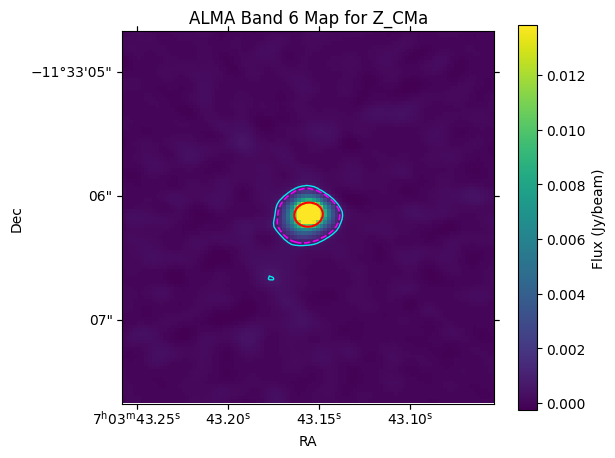

In [1]:
# Import required libraries
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.modeling import models, fitting
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter('ignore', category=FITSFixedWarning)

# Load FITS file
filename = "C:/Users/maitr/Downloads/member.uid___A001_X88b_X15.Z_CMa_sci.spw25_27_29_31_33_35.cont.I.pbcor.fits"
hdulist = fits.open(filename)
image_data = hdulist[0].data.squeeze()
header = hdulist[0].header

# Extract beam size in arcsec
bmaj_deg = header.get('BMAJ', np.nan)
bmin_deg = header.get('BMIN', np.nan)
bmaj_arcsec = bmaj_deg * 3600 if bmaj_deg else None
bmin_arcsec = bmin_deg * 3600 if bmin_deg else None

# Determine ALMA Band
band = header.get('RESTFRQ', None)
if band:
    if 84e9 <= band < 116e9:
        band_name = "Band 3"
    elif 125e9 <= band < 163e9:
        band_name = "Band 4"
    elif 163e9 <= band < 211e9:
        band_name = "Band 5"
    elif 211e9 <= band < 275e9:
        band_name = "Band 6"
    elif 275e9 <= band < 373e9:
        band_name = "Band 7"
    elif 602e9 <= band < 720e9:
        band_name = "Band 9"
    else:
        band_name = "Unknown"
else:
    band_name = "Not Found"

# RMS estimation
flattened = image_data.flatten()
flattened = flattened[~np.isnan(flattened)]
rms = np.std(flattened[np.abs(flattened) < 5 * np.std(flattened)])

print(f"Band: {band_name}")
print(f"Beam size: BMAJ = {bmaj_arcsec:.2f} arcsec, BMIN = {bmin_arcsec:.2f} arcsec")
print(f"Estimated RMS noise: {rms:.5f} Jy/beam")

# Get WCS
wcs = WCS(header).celestial

# -------------------------------
# Zoom into brightest region
# -------------------------------
peak_pos = np.unravel_index(np.nanargmax(image_data), image_data.shape)
x_peak, y_peak = peak_pos[1], peak_pos[0]
box_size = 50  # pixels

x_min = max(x_peak - box_size, 0)
x_max = min(x_peak + box_size, image_data.shape[1])
y_min = max(y_peak - box_size, 0)
y_max = min(y_peak + box_size, image_data.shape[0])

zoom_data = image_data[y_min:y_max, x_min:x_max]
zoom_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))

# -------------------------------
# 2D Gaussian Fit
# -------------------------------
# Initial guess
y, x = np.mgrid[:zoom_data.shape[0], :zoom_data.shape[1]]
p_init = models.Gaussian2D(amplitude=np.nanmax(zoom_data),
                           x_mean=zoom_data.shape[1] / 2,
                           y_mean=zoom_data.shape[0] / 2,
                           x_stddev=5,
                           y_stddev=5,
                           theta=0)

# Fit the data
fit_p = fitting.LevMarLSQFitter()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, zoom_data)

# -------------------------------
# Plot with contours and ellipse
# -------------------------------
plt.figure(figsize=(6, 5))
ax = plt.subplot(projection=zoom_wcs)
norm = simple_norm(zoom_data, 'linear', percent=99.5)
im = ax.imshow(zoom_data, origin='lower', cmap='viridis', norm=norm)

# Draw 3×RMS contour in white
ax.contour(zoom_data, levels=[3 * rms], colors='cyan', linewidths=1.0, alpha=0.9, linestyles='solid')

# Draw 5×RMS contour in magenta
ax.contour(zoom_data, levels=[5 * rms], colors='magenta', linewidths=1.2, alpha=0.9, linestyles='dashed')

# Draw Gaussian ellipse
from matplotlib.patches import Ellipse

def draw_ellipse(ax, model, edgecolor='red'):
    width = 2.355 * model.x_stddev.value
    height = 2.355 * model.y_stddev.value
    angle = np.degrees(model.theta.value)
    ell = Ellipse((model.x_mean.value, model.y_mean.value),
                  width, height, angle=angle,
                  edgecolor=edgecolor, facecolor='none', lw=1.5)
    ax.add_patch(ell)

draw_ellipse(ax, p)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title(f"ALMA {band_name} Map for Z_CMa")
plt.colorbar(im, ax=ax, label='Flux (Jy/beam)')
plt.show()
